In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

c:\Users\emirh\anaconda3\envs\tlib\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Getting a dataset
train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor(), target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)


In [3]:
# First training sample
image, label = train_data[0]
image.shape


torch.Size([1, 28, 28])

In [4]:
# How many samples are there?
print(
    f"""---- TRAIN DATA ----
Length of features: {len(train_data.data)} \nLength of target: {len(train_data.targets)}
---- TEST DATA ----
Length of features: {len(test_data.data)} \nLength of target: {len(test_data.targets)}"""
)


---- TRAIN DATA ----
Length of features: 60000 
Length of target: 60000
---- TEST DATA ----
Length of features: 10000 
Length of target: 10000


In [5]:
# Classes name
class_name = train_data.classes
class_name  # There are 10 different classes, it means our problem is multi-class classification.


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

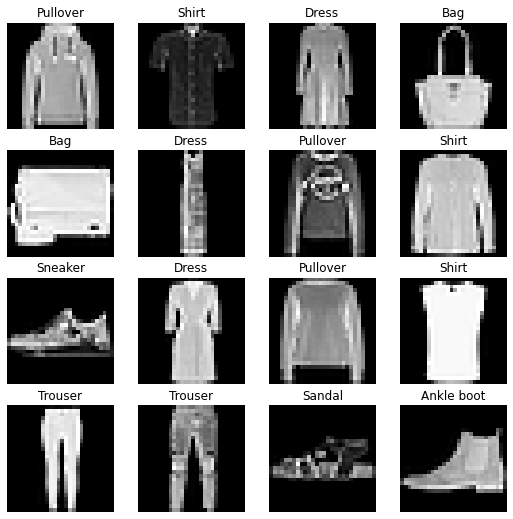

In [6]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    rnd_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rnd_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_name[label])
    plt.axis(False)


In [7]:
# DataLoader: Combines a dataset and a sampler, and provides an iterable over the given dataset
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))


In [10]:
train_features_batch.shape, train_labels_batch.shape
# [batch_size,color,height,width]

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"


### Building Baseline Model

In [12]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer(x)


model_0 = FashionMNISTModelV0(
    input_shape=784, output_shape=len(train_data.classes), hidden_units=10
)
model_0.to(device)


FashionMNISTModelV0(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [13]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)


In [14]:
torch.manual_seed(42)
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train()
        # forward pass
        y_pred = model_0(X)
        # Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # Calculate accuracy (per batch)
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        # Optimizer zero grad
        optimizer.zero_grad()
        # Backward pro
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(
        f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% \nTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% "
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------


 33%|███▎      | 1/3 [00:33<01:06, 33.21s/it]

Train loss: 0.59075 | Train accuracy: 0.79% 
Test loss: 0.51143 | Test accuracy: 0.82% 
Epoch: 1
-------


 67%|██████▋   | 2/3 [01:07<00:33, 33.72s/it]

Train loss: 0.47873 | Train accuracy: 0.83% 
Test loss: 0.48527 | Test accuracy: 0.83% 
Epoch: 2
-------


100%|██████████| 3/3 [01:35<00:00, 31.98s/it]

Train loss: 0.45620 | Train accuracy: 0.84% 
Test loss: 0.47878 | Test accuracy: 0.84% 


### Evaluate model prediction

In [15]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return pd.DataFrame(
        {
            "model": model.__class__.__name__,
            "loss": np.round(loss.item(), 4),
            "acc": f"{np.round(acc.item(),4)*100}%",
        },
        index=[0],
    )


In [16]:
model_0_results = eval_model(
    model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results


,model,loss,acc
0,FashionMNISTModelV0,0.4788,83.55%


### Improving Baseline Model

In [17]:
# Adding relu layer for non-linearity
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor):
        return self.layer(x)


In [18]:
model_1 = FashionMNISTModelV1(
    input_shape=784, hidden_units=10, output_shape=len(train_data.classes)
).to(device)


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(
    device
)


### Functionizing training and test loops

In [20]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataset,
    loss_fn: nn.Module,
    accuracy_fn: torchmetrics,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"train loss: {train_loss:.4f} | train acc: {train_acc:.2f}%")


In [21]:
def test_step(model: nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                accuracy_fn:torchmetrics,
                device: torch.device=device):
                
    test_loss,test_acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred,y)
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"test loss: {test_loss:.4f} | test acc: {test_acc:.2f}%\n")
     

In [22]:
torch.manual_seed(42)
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n---------")
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        optimizer=optimizer,
        device=device,
    )
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
train loss: 0.9289 | train acc: 0.70%


 33%|███▎      | 1/3 [00:31<01:03, 31.70s/it]

test loss: 0.5421 | test acc: 0.81%

Epoch: 2
---------
train loss: 0.4988 | train acc: 0.82%


 67%|██████▋   | 2/3 [00:55<00:27, 27.29s/it]

test loss: 0.5037 | test acc: 0.82%

Epoch: 3
---------
train loss: 0.4625 | train acc: 0.83%


100%|██████████| 3/3 [01:22<00:00, 27.44s/it]

test loss: 0.4854 | test acc: 0.83%



In [23]:
model_1_result = eval_model(
    model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
)


In [24]:
model_0_results

,model,loss,acc
0,FashionMNISTModelV0,0.4788,83.55%


In [25]:
model_1_result

,model,loss,acc
0,FashionMNISTModelV1,0.4854,83.05%
